# **My electrophoresis sense is tingling. 🕷️ Predicting maintenance.**

---
## **Overview**
* Dataset source : [E-coating ultrafiltration maintenance](https://www.kaggle.com/boyangs444/process-data-for-predictive-maintenance) sensors dataset for a 20 year old electrophoresis plant
* Dataset type : multivariate time series
* Goal : predict the flow rate (`FM1`) using sensor readings from the past 3 hours

\
⚠️ **NOTE** : This is not an end to end project. It is an experiment to use neural networks to predict time series data.


## **The problem**
In manufacturing plants machinery will require maintenance over time. The problem is that if there is no maintenance then there will be failures, potential injuries and costs associated for repairs.

The other downside is staffing. If you do not have predictive maintenance inplace and it is important to fix problems ASAP then you will require skilled staff available almost 24/7, that in inefficient use of budget and people's time. With predictive maintenance you may not be able to be 100% accurate but even if it's 80% accurate I see that as a win given the efficiency gains.

## **Setup**
`fast.ai` has a number of unofficial extensions that people have developed. I'm using `tsai` [repo here](https://github.com/timeseriesAI/tsai) which focuses on time series. It was created by *Ignacio Oguiza*.

Some examples of uses/functions are:
* Classification, regression and forecasting
* Prepping time series data appropriately
* Converting time series datasets into images

Along with this library there are some other libraries used for plotting and data processing.


In [2]:
!pip install tsai -Uqq --upgrade # Colab was used hence the install

     |████████████████████████████████| 143kB 9.1MB/s 
     |████████████████████████████████| 5.7MB 9.4MB/s 
     |████████████████████████████████| 9.5MB 52.7MB/s 
     |████████████████████████████████| 194kB 46.2MB/s 
     |████████████████████████████████| 2.5MB 52.7MB/s 
     |████████████████████████████████| 22.3MB 65.8MB/s 
     |████████████████████████████████| 92kB 13.9MB/s 
     |████████████████████████████████| 215kB 56.4MB/s 
     |████████████████████████████████| 3.2MB 48.7MB/s 
     |████████████████████████████████| 901kB 46.3MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 675kB 49.6MB/s 
     |████████████████████████████████| 25.3MB 141kB/s 


In [3]:
from tsai.all import * # tsai
import pandas as pd # Data processing
import plotly.express as px # Plots
import plotly.graph_objects as go # Plot objects

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## **Data**
The data is from a electrophoresis painting plant that is 20 years old. The dataset is for a 14 day period where sensors are used to log the following sensor values:
* **Pressure** - `PE1`, `PE2`, `PE3`, `PE4`
* **Temperature** - `TP1`, `TP2`
* **Flow** - `FM1` (target)

The data has already been normalised hence very little preprocess is required.

In [102]:
iot = pd.read_csv("iiot_30min_norm.csv") # Read in data

iot["TIME"] = pd.to_datetime(iot["TIME"], infer_datetime_format = True) # Make sure TIME is in datetime format

In [103]:
iot.head()

,TIME,FM1,PE1,PE2,PE3,PE4,TP1,TP2,EPOCH
0,2020-07-05 21:00:00+00:00,0.291841,0.944212,0.969845,0.909817,0.752879,0.128703,0.729592,1593982800
1,2020-07-05 21:30:00+00:00,0.290384,0.947971,0.971459,0.913576,0.753741,0.117572,0.723905,1593984600
2,2020-07-05 22:00:00+00:00,0.279458,0.944138,0.968994,0.912516,0.753187,0.111242,0.720671,1593986400
3,2020-07-05 22:30:00+00:00,0.288927,0.950337,0.976253,0.915991,0.756699,0.102464,0.716186,1593988200
4,2020-07-05 23:00:00+00:00,0.299610,0.950226,0.975747,0.916188,0.756563,0.093201,0.711454,1593990000


## **Plots**


Before plotting and modelling I need to see if all data points have the same duration between them (they do).

In [104]:
time_diff = iot["TIME"] - iot["TIME"].shift() # Take the current row and subtract the adjacent row
time_diff.unique() # All dates are 30 mins apart

array([        'NaT', 1800000000000], dtype='timedelta64[ns]')

The data can be plotted as such.

In [105]:
fig = px.line(iot, x = "TIME", y = "FM1")
for col in ["PE2", "PE1",	"PE2", "PE3", "PE4", "TP1", "TP2"]:
  fig.add_scatter(x = iot['TIME'], y = iot[col], mode = 'lines', name = col)
fig.show()

Looking at the `FM1` values will help decide whether or not to **weight the loss function**.

In [106]:
px.histogram(iot, x ="FM1", nbins = 200) # Each bin should be approximately 0.05 in size

It is clear that the majority of `FM1` values are between 0.2 and 0.6 so they should be easier to predict while the values closer to 1 will be harder given there are less examples. So a weighted loss function will be used in training.

In [107]:
def weighted_l1_loss(inp, targ, weight_fn = None):
    if weight_fn is not None:
        return (F.l1_loss(*flatten_check(inp,targ), reduction = 'none') * weight_fn(targ)).mean()
    else:
        return F.l1_loss(*flatten_check(inp,targ))

def weight_fn(targ, min = 0, max = 1):
    targ = TensorBase(targ.contiguous()).view(-1)
    weight = 1 + torch.clamp((targ - min)/(max - min), 0, 1)
    return weight

loss_func = partial(weighted_l1_loss, weight_fn = weight_fn)

## **Setting up TSAI/the data**
### Sliding window
The way the data is being split is by using `SlidingWindow`. The way this works is by specifying
* `window_len` - the length of a sequence (in this case 6 is used as we want to predict 3 hours in the future and each data point is 30 minutes)
* `get_x` - the columns to use (indicies of columns used)
* `get_y` - the target column (name used)
* `stride` - how much to move the window by each time
* `horizon` - how far from the last data point to predict (1 is saying to predict the next y after the 3 hour chunk)
* `ascending` - sort by ascending order
* `seq_first` - used as it's a dataframe


Visually it is like this.

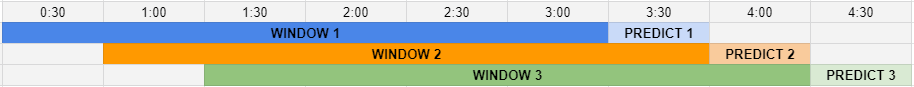

In [108]:
X, y = SlidingWindow(window_len = 6, get_x = [2, 3, 4, 5, 6], get_y = "FM1", stride = 1, horizon = 1, sort_by = ["TIME"], ascending = True, seq_first = True)(iot) # Split into windows
X[0:2], y[0:2] # Two examples of windows, notice Xs consist of multiple arrays as there are multiple Xs (each x is a sensor input)

(array([[[0.9442119 , 0.94797057, 0.9441379 , 0.9503366 , 0.9502257 ,
          0.94583863],
         [0.9698446 , 0.97145903, 0.9689942 , 0.9762528 , 0.97574747,
          0.97476155],
         [0.9098173 , 0.91357595, 0.91251606, 0.9159912 , 0.9161884 ,
          0.91490686],
         [0.75287855, 0.75374126, 0.7531867 , 0.7566987 , 0.75656325,
          0.7560704 ],
         [0.12870277, 0.11757235, 0.11124238, 0.10246424, 0.0932012 ,
          0.09090909]],
 
        [[0.94797057, 0.9441379 , 0.9503366 , 0.9502257 , 0.94583863,
          0.9464547 ],
         [0.97145903, 0.9689942 , 0.9762528 , 0.97574747, 0.97476155,
          0.97091264],
         [0.91357595, 0.91251606, 0.9159912 , 0.9161884 , 0.91490686,
          0.9119636 ],
         [0.75374126, 0.7531867 , 0.7566987 , 0.75656325, 0.7560704 ,
          0.7520776 ],
         [0.11757235, 0.11124238, 0.10246424, 0.0932012 , 0.09090909,
          0.091888  ]]]), array([0.2741165, 0.2799436]))

### Splits
With the data in "windows" it can now be split into training and validation datasets. It is important to not shuffle the data as the aim is to forecast the future.

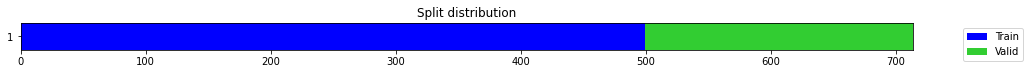

In [109]:
splits = get_splits(y, valid_size = .3, random_state = 23, shuffle = False) # Split

### Dataloaders

After splitting the data, dataloaders can now be created. `TSForecasting` must be declared given the task is to forecast `FM1`. Interestingly `shuffle_train` is set to `True`. The reason for this is because it means the training data is shuffled  there isn't any data leakage when the training data is shuffled

In [110]:
tfms  = [None, TSForecasting()]
dls = get_ts_dls(X, y, tfms = tfms, splits = splits, bs = 8, shuffle_train = True, device = default_device(use_cuda = True), inplace = True)

Check if the training and validation data is being shuffled appropriately (it is).

In [111]:
dls.train.shuffle, dls.valid.shuffle

(True, False)

Check can be done to see if it is a single input (what is required) before creating a model (it is).

In [112]:
dls.c

1

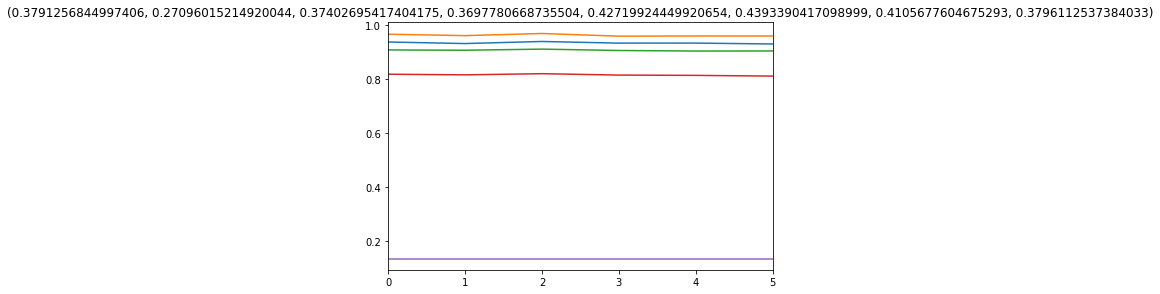

In [113]:
dls.show(dls.one_batch()) # Example of a batch

## **Baseline model**
With everything setup a `ts_learner` can be created with inputs:
* The dataloaders - `dls`
* Model architecture - `InceptionTime` (used here as it is often a model architecture used for time series regression/forecasting)
* Metrics - `mae` (important here as y's are between 0 and 1)
* Device - set to use gpu

`InceptionTime` is a model architecture that is commonly used for time series given it's high performance. The architecture has been implemented in `tsai` and is the preferred method for this task. 

In [128]:
learn = ts_learner(dls, InceptionTime, metrics = mae, device = default_device(use_cuda = True), loss_func = loss_func)

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=1.3182567499825382e-06)

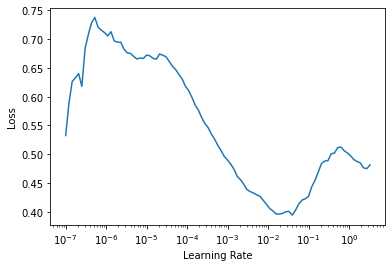

In [129]:
learn.lr_find() # Find suitable lr

epoch,train_loss,valid_loss,mae,time
0,0.309413,0.221577,0.157755,00:01


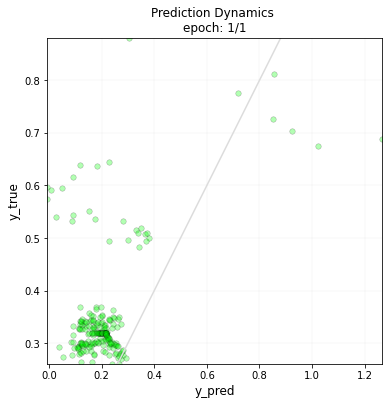

,train_loss,valid_loss,mae
0,0.309413,0.221577,0.157755


epoch,train_loss,valid_loss,mae,time
0,0.134562,0.205201,0.143657,00:01
1,0.123502,0.185649,0.130580,00:01
2,0.113865,0.147744,0.103947,00:01
3,0.109255,0.114473,0.077958,00:01
4,0.103810,0.135822,0.095889,00:01
5,0.101900,0.130648,0.088504,00:01
6,0.095165,0.148513,0.104494,00:01
7,0.099072,0.145108,0.099594,00:01
8,0.100787,0.181228,0.129309,00:01
9,0.101132,0.115576,0.078335,00:01


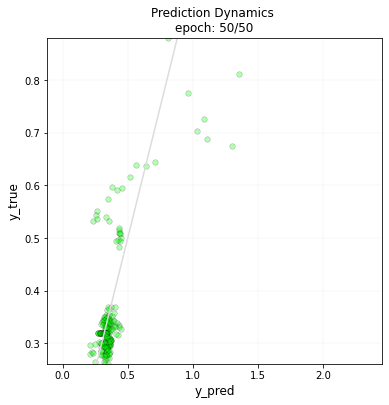

,train_loss,valid_loss,mae
49,0.059556,0.081653,0.055845


In [130]:
# Training loop
# - Fit for 50 epochs
# - Learning rate at 1e-4
# - Use PredictionDynamics callback to see the predictions after each epoch/at the end of training
# - Add a tiny bit of weight decay to lessen overfitting
learn.fine_tune(50, 1e-4, cbs = [PredictionDynamics])

In [131]:
def get_residuals(learner, dls):
  # Get predictions and actuals
  valid_preds, valid_actuals = learner.get_preds(ds_idx = 1, dl = dls.valid)

  # Put the actual against the prediction in a dataframe
  results = pd.DataFrame({"actual" : valid_actuals.flatten().tolist(), 
                          "pred" : valid_preds.flatten().tolist()})

  # Calculate the residual
  results["residual"] = results["actual"] - results["pred"]

  return results

def residual_plot(residuals):
  # Plot the actuals and show the residual, line represents 0 residual i.e. accurate prediction
  fig = px.scatter(residuals, x = "actual", y = "residual")
  fig.add_shape(type = 'line',
                x0 = 0,
                y0 = 0,
                x1 = 1,
                y1 = 0,
                line = dict(color = 'Red'),
                opacity = 0.5)
  
  # Text
  fig.add_trace(go.Scatter(
      x = [0],
      y = [-0.05],
      mode = "text",
      text = ["Overpredicting"],
      textposition = "bottom center"
  ))

  fig.add_trace(go.Scatter(
      x = [0],
      y = [0.05],
      mode = "text",
      text = ["Underpredicting"],
      textposition = "top center"
  ))
  
  return fig

In [132]:
residuals = get_residuals(learner = learn, dls = dls)

residual_plot(residuals)

Could not do one pass in your dataloader, there is something wrong in it


So the final metrics look good but looking at the graph from the prediction dynamics and residuals there are some interesting results for the model.

1. It predicts lower `FM1` more accurately
2. It over predicts upper `FM1` 
3. It under predicts mid `FM1`

In the context of the problem it is better to **overpredict** `FM1` given we want to catch high flow rates before they get out of control. Point **2** I don't see it being as problematic as it may seem as it is overpredicting but that would mean someone would look into it.

## **Comparing models**
The baseline model doesn't have any hyperparameter tweaks. After experimenting with different hyperparameters the results can vary significantly for this particular problem. I do not want to spend time guessing hyperparameters so a mini grid search loop has been created to find potentially optimal values (bayesian optimisation could also be used but I want a more exhaustive search).

In [133]:
archs = []

# Create InceptionTime models with different hyperparameters
for y in range(10, 14):
  for x in range(1, 10):
    archs.append((InceptionTime, {"nf" : y,
                                  "ks" : x * 5}))

# Examples of architecures and inputs
archs[0:5]

[(tsai.models.InceptionTime.InceptionTime, {'ks': 5, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 10, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 15, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 20, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 25, 'nf': 10})]

### Run the grid search

In [134]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'mae', 'time']) # Create dataframe for results

for i, (arch, k) in enumerate(archs):
    
    # Initialise the model
    model = create_model(arch, dls = dls, **k)
    print(model.__class__.__name__)
    
    # Create the fastai/tsai learner
    learn = Learner(dls, model,  metrics = mae, loss_func = loss_func)

    # Initialise the start time
    start = time.time()

    # Fit for
    # - 50 epochs
    # - 1e-4 learning rate (decreasing over time)
    # - 0.01 weight decay
    # - Print the actual vs predicted graph using PredictionDynamics callback after each epoch
    learn.fine_tune(50, 1e-4, cbs = PredictionDynamics, wd = 0.01)

    # Calculate and store time taken
    elapsed = time.time() - start
    
    # Take the results and store them in the results dataframe
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, total_params(model)[0], vals[0], vals[1], vals[2], int(elapsed)]
    
    # Sort the results by mae and display the current results
    results.sort_values(by = 'mae', ascending = True, ignore_index = True, inplace = True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,mae,time
0,InceptionTime,"{'nf': 11, 'ks': 30}",42945,0.072634,0.090263,0.061166,94
1,InceptionTime,"{'nf': 13, 'ks': 30}",59749,0.071574,0.105413,0.073426,99
2,InceptionTime,"{'nf': 11, 'ks': 45}",61821,0.075255,0.112084,0.080958,95
3,InceptionTime,"{'nf': 11, 'ks': 10}",16809,0.084857,0.127246,0.083664,94
4,InceptionTime,"{'nf': 11, 'ks': 20}",29877,0.071574,0.125325,0.084108,95
5,InceptionTime,"{'nf': 12, 'ks': 30}",51001,0.067144,0.122031,0.088264,96
6,InceptionTime,"{'nf': 11, 'ks': 15}",24069,0.077046,0.138269,0.092387,93
7,InceptionTime,"{'nf': 12, 'ks': 20}",35449,0.075911,0.138470,0.096285,94
8,InceptionTime,"{'nf': 10, 'ks': 25}",29581,0.069713,0.139620,0.097077,94
9,InceptionTime,"{'nf': 12, 'ks': 25}",42361,0.075262,0.139890,0.097343,95


In [135]:
learn = ts_learner(dls, InceptionTime, metrics = mae, device = default_device(use_cuda = True), loss_func = loss_func, nf = 11, ks = 30)

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.005248074419796467)

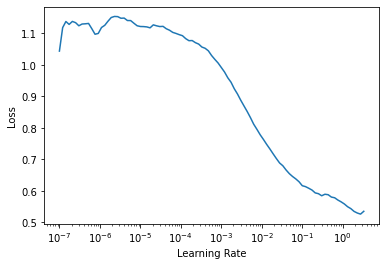

In [136]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,time
0,0.250510,0.702936,0.520626,00:01


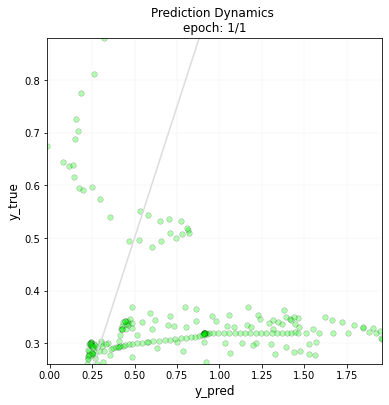

,train_loss,valid_loss,mae
0,0.25051,0.702936,0.520626


epoch,train_loss,valid_loss,mae,time
0,0.114694,0.167008,0.120302,00:01
1,0.117788,0.148711,0.108028,00:01
2,0.106978,0.285163,0.210183,00:01
3,0.096871,0.334793,0.248966,00:01
4,0.097055,0.068492,0.048630,00:01
5,0.097923,0.212892,0.152099,00:01
6,0.097388,0.540126,0.398858,00:01
7,0.102657,0.220676,0.162794,00:01
8,0.095891,0.097269,0.067459,00:01
9,0.098510,0.169352,0.122511,00:01


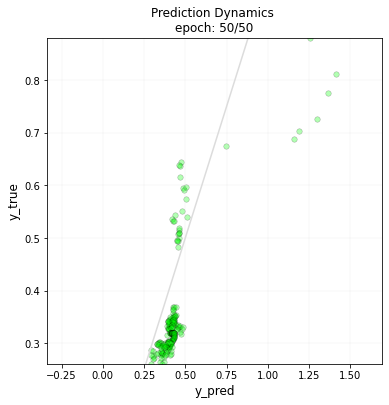

,train_loss,valid_loss,mae
49,0.0616,0.141226,0.100613


In [137]:
learn.fine_tune(50, 1e-2, cbs = PredictionDynamics, wd = 0.01)

### Residual check

In [138]:
residuals = get_residuals(learner = learn, dls = dls)

residual_plot(residuals)

Could not do one pass in your dataloader, there is something wrong in it


So after using some hyperparameter tuning the model has a higher `mae`. 

Observations
* The residuals are now higher for mid values of `FM1`
* Higher values of `FM1` are being predicted better 
* Lower values of `FM1` are now being overpredicting rather than having mixture of over and under prediction

## **Test with using previous flow rate to predict flow rate**
Rather than using other sensory inputs an alternative approach can be to use previous flow rates to predict the next flow rate. This can be done by replacing `get_x` with `FM1` and making sure horizon is set to 0+. Again splits and dataloaders can be created.

In [139]:
X, y = SlidingWindow(window_len = 6, get_x = "FM1", get_y = "FM1", stride = 1, horizon = 1, sort_by = ["TIME"], ascending = True, seq_first = True)(iot) # Split into windows
X[0:2], y[0:2] # Two examples of windows, notice Xs consist of multiple arrays as there are multiple Xs (each x is a sensor input)

(array([[[0.29184058, 0.29038382, 0.27945802, 0.28892702, 0.29961005,
          0.2963323 ]],
 
        [[0.29038382, 0.27945802, 0.28892702, 0.29961005, 0.2963323 ,
          0.2741165 ]]]), array([0.2741165, 0.2799436]))

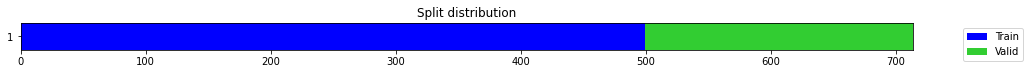

In [140]:
splits = get_splits(y, valid_size = .3, random_state = 23, shuffle = False) # Split

In [141]:
tfms  = [None, TSForecasting()]
dls = get_ts_dls(X, y, tfms = tfms, splits = splits, bs = 8, shuffle_train = True, device = default_device(use_cuda = True), inplace = True)

### Grid search loop

In [142]:
archs = []

# Create InceptionTime models with different hyperparameters
for y in range(10, 14):
  for x in range(1, 10):
    archs.append((InceptionTime, {"nf" : y,
                                  "ks" : x * 5}))

archs[0:5]

[(tsai.models.InceptionTime.InceptionTime, {'ks': 5, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 10, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 15, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 20, 'nf': 10}),
 (tsai.models.InceptionTime.InceptionTime, {'ks': 25, 'nf': 10})]

In [143]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'mae', 'time']) # Create dataframe for results

for i, (arch, k) in enumerate(archs):
    
    # Initialise the model
    model = create_model(arch, dls = dls, **k)
    print(model.__class__.__name__)
    
    # Create the fastai/tsai learner
    learn = Learner(dls, model,  metrics = mae, cbs = TrackerCallback(monitor = "mae"), loss_func = loss_func)

    # Initialise the start time
    start = time.time()

    # Fit for 
    # - 50 epochs
    # - 1e-3 learning rate (decreasing over time)
    # - 0.01 weight decay
    # - Print the actual vs predicted graph using PredictionDynamics callback after each epoch
    learn.fine_tune(50, 1e-3, cbs = [PredictionDynamics], wd = 0.01)

    # Calculate and store time taken
    elapsed = time.time() - start
    
    # Take the results and store them in the results dataframe
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, total_params(model)[0], vals[0], vals[1], vals[2], int(elapsed)]
    
    # Sort the results by mae and display the current results
    results.sort_values(by = 'mae', ascending = True, ignore_index = True, inplace = True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,mae,time
0,InceptionTime,"{'nf': 10, 'ks': 40}",38901,0.029632,0.018341,0.012101,95
1,InceptionTime,"{'nf': 11, 'ks': 10}",14884,0.028484,0.019016,0.012547,94
2,InceptionTime,"{'nf': 13, 'ks': 35}",58332,0.028463,0.019515,0.012900,92
3,InceptionTime,"{'nf': 13, 'ks': 40}",65196,0.034176,0.019485,0.013046,94
4,InceptionTime,"{'nf': 12, 'ks': 10}",17617,0.034442,0.021398,0.014575,95
5,InceptionTime,"{'nf': 12, 'ks': 25}",36649,0.029493,0.022041,0.014750,91
6,InceptionTime,"{'nf': 11, 'ks': 15}",21044,0.030419,0.022460,0.014953,93
7,InceptionTime,"{'nf': 13, 'ks': 25}",42888,0.033438,0.022209,0.014992,97
8,InceptionTime,"{'nf': 12, 'ks': 20}",30793,0.027055,0.022881,0.015086,97
9,InceptionTime,"{'nf': 10, 'ks': 25}",25641,0.029213,0.023243,0.015455,94


In [144]:
learn = ts_learner(dls, InceptionTime, metrics = mae, device = default_device(use_cuda = True), loss_func = loss_func, nf = 10, ks = 40)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.0010000000474974513)

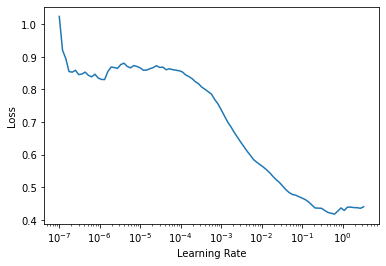

In [145]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,time
0,0.293518,0.176968,0.121778,00:01


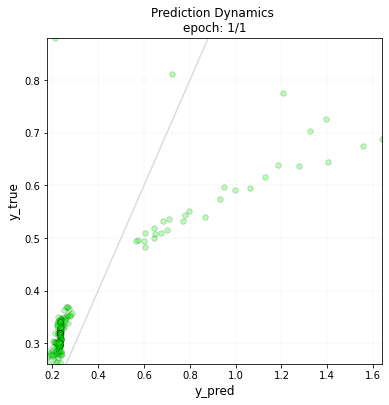

,train_loss,valid_loss,mae
0,0.293518,0.176968,0.121778


epoch,train_loss,valid_loss,mae,time
0,0.083027,0.058467,0.041257,00:01
1,0.071765,0.042328,0.028221,00:01
2,0.063991,0.044657,0.029807,00:01
3,0.063880,0.030601,0.019541,00:01
4,0.058032,0.048551,0.033063,00:01
5,0.065536,0.051444,0.033539,00:01
6,0.064495,0.049266,0.034758,00:01
7,0.063896,0.043465,0.027896,00:01
8,0.060599,0.070857,0.049905,00:01
9,0.064386,0.122966,0.091044,00:01


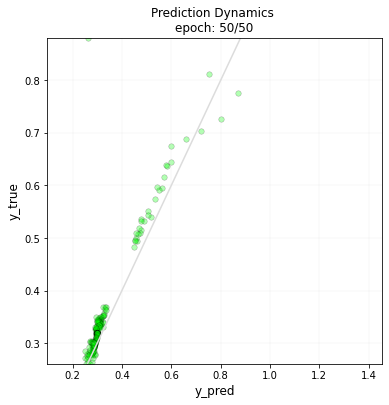

,train_loss,valid_loss,mae
49,0.031701,0.038597,0.026594


In [146]:
learn.fine_tune(50, 1e-3, cbs = PredictionDynamics)

### Residual check

In [147]:
residuals = get_residuals(learner = learn, dls = dls)

residual_plot(residuals)

Could not do one pass in your dataloader, there is something wrong in it


Again after using some hyperparameter tuning the model has a lower `mae`. 

Observations
* The residuals for mid values of `FM1` are now more stable
* One upper value of `FM1` is being underpredicted (not good)
* Lower values of `FM1` are stable again

## InceptionTime previous FM1 rate

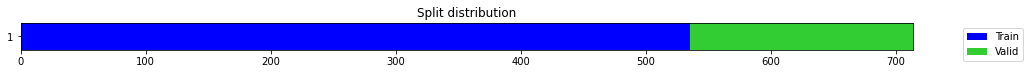

In [148]:
X, y = SlidingWindow(window_len = 6, get_x = "FM1", get_y = "FM1", start = 0, stride = 1, horizon = 1, sort_by = ["TIME"], ascending = True, seq_first = True)(iot) # Split into windows

splits = get_splits(y, valid_size = .25, random_state = 23, shuffle = False) # Split

tfms  = [None, TSForecasting()]
dls_previous = get_ts_dls(X, y, tfms = tfms, splits = splits, bs = 8, shuffle_train = True, device = default_device(use_cuda = True), inplace = True)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=2.75422871709452e-06)

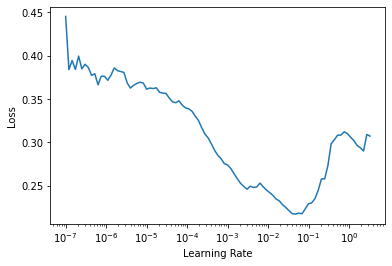

In [149]:
learn_previous = ts_learner(dls_previous, InceptionTime, metrics = mae, device = default_device(use_cuda = True), loss_func = loss_func, nf = 10, ks = 40)

learn_previous.lr_find()

epoch,train_loss,valid_loss,mae,time
0,0.140764,0.238142,0.177272,00:01


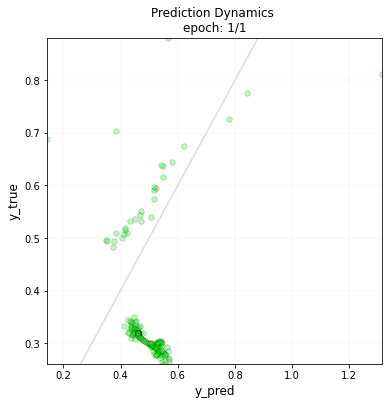

,train_loss,valid_loss,mae
0,0.140764,0.238142,0.177272


epoch,train_loss,valid_loss,mae,time
0,0.075090,0.123337,0.082952,00:01
1,0.062858,0.066832,0.042268,00:01
2,0.061669,0.056003,0.036928,00:01
3,0.057305,0.053673,0.034175,00:01
4,0.055492,0.057071,0.037313,00:01
5,0.059262,0.045898,0.030405,00:01
6,0.058580,0.038040,0.024150,00:01
7,0.064656,0.063553,0.042057,00:01
8,0.058792,0.052530,0.033767,00:01
9,0.058908,0.069491,0.046550,00:01


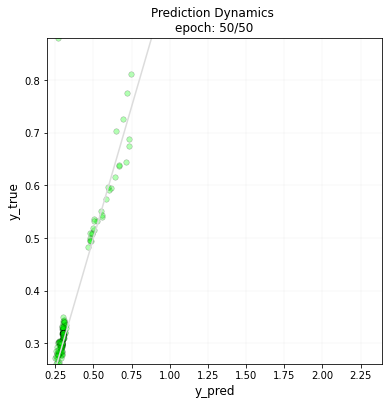

,train_loss,valid_loss,mae
49,0.034488,0.031336,0.021286


In [150]:
learn_previous.fine_tune(50, 1e-3, cbs = [PredictionDynamics], wd = 0.01)

In [151]:
residuals_previous = get_residuals(learner = learn_previous, dls = dls_previous)

residual_plot(residuals_previous)

Could not do one pass in your dataloader, there is something wrong in it


## InceptionTime multi variate

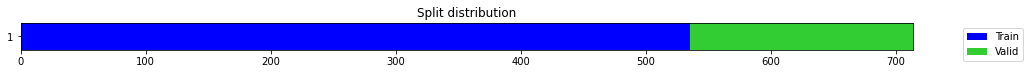

In [152]:
X, y = SlidingWindow(window_len = 6, get_x = [2, 3, 4, 5, 6], get_y = "FM1", start = 0, stride = 1, horizon = 1, sort_by = ["TIME"], ascending = True, seq_first = True)(iot) # Split into windows

splits = get_splits(y, valid_size = .25, random_state = 23, shuffle = False) # Split

tfms  = [None, TSForecasting()]
dls_multi_var = get_ts_dls(X, y, tfms = tfms, splits = splits, bs = 8, shuffle_train = True, device = default_device(use_cuda = True), inplace = True)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=1.3182567499825382e-06)

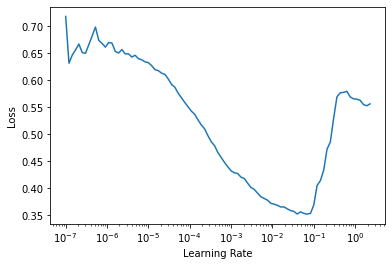

In [153]:
learn_multi_var = ts_learner(dls_multi_var, InceptionTime, metrics = mae, device = default_device(use_cuda = True), loss_func = loss_func)
learn_multi_var.lr_find()

epoch,train_loss,valid_loss,mae,time
0,0.225375,0.296138,0.210037,00:01


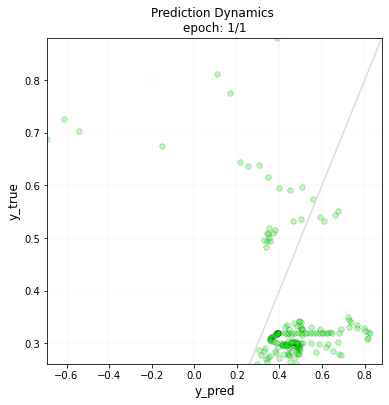

,train_loss,valid_loss,mae
0,0.225375,0.296138,0.210037


epoch,train_loss,valid_loss,mae,time
0,0.108782,0.108948,0.075105,00:01
1,0.098056,0.064142,0.043693,00:01
2,0.109660,0.163451,0.119577,00:01
3,0.105221,0.094594,0.068575,00:01
4,0.102460,0.115144,0.083642,00:01
5,0.107766,0.173076,0.127457,00:01
6,0.100128,0.107572,0.076377,00:01
7,0.099714,0.163999,0.118099,00:01
8,0.100156,0.129768,0.090691,00:01
9,0.098624,0.109022,0.075878,00:01


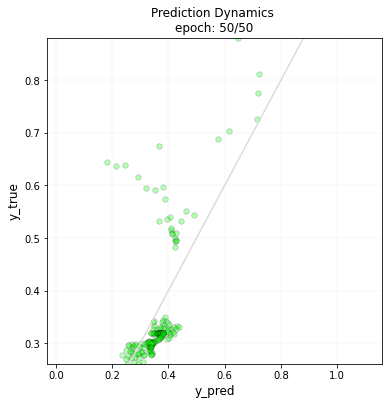

,train_loss,valid_loss,mae
49,0.060883,0.090891,0.062986


In [154]:
learn_multi_var.fine_tune(50, 1e-3, cbs = PredictionDynamics, wd = 0.01)

In [155]:
residuals_multi_var = get_residuals(learner = learn_multi_var, dls = dls_multi_var)

residual_plot(residuals_multi_var)

Could not do one pass in your dataloader, there is something wrong in it


In [156]:
residuals_multi_var, residuals_previous

(       actual      pred  residual
 0    0.342342  0.348914 -0.006572
 1    0.331538  0.350089 -0.018551
 2    0.315756  0.349476 -0.033720
 3    0.326682  0.345745 -0.019063
 4    0.339550  0.345878 -0.006328
 ..        ...       ...       ...
 173  0.509871  0.425295  0.084577
 174  0.494696  0.423546  0.071150
 175  0.483042  0.422960  0.060082
 176  0.495382  0.425203  0.070179
 177  0.495130  0.425883  0.069247
 
 [178 rows x 3 columns],        actual      pred  residual
 0    0.342342  0.308036  0.034306
 1    0.331538  0.313438  0.018100
 2    0.315756  0.304624  0.011131
 3    0.326682  0.300096  0.026586
 4    0.339550  0.305865  0.033685
 ..        ...       ...       ...
 173  0.509871  0.475344  0.034527
 174  0.494696  0.481858  0.012839
 175  0.483042  0.462580  0.020462
 176  0.495382  0.477502  0.017881
 177  0.495130  0.480429  0.014701
 
 [178 rows x 3 columns])

In [157]:
a = pd.DataFrame(columns = ["actual", "pred"])

for x in range(0, len(residuals_multi_var)):
  b = pd.DataFrame({"actual" : residuals_multi_var.actual.loc[x], 
                    "pred" : (residuals_multi_var.pred.loc[x] + residuals_previous.pred.loc[x])/2}, 
                   columns = ["actual", "pred"], index=[0])
  a = pd.concat([a, b])

In [158]:
a["residual"] = a["actual"] - a["pred"]

In [159]:
residual_plot(residuals_previous)

In [160]:
residual_plot(residuals_multi_var)

In [161]:
residual_plot(a)